In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Label_Data.parse(Label_Data.sheet_names[1])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(127, 300)
(127, 1)


In [3]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(198, 300)
(198, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)


In [4]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,-0.135266,-0.059643,0.025812,0.055720,-0.258434,-0.093272,-0.311657,-0.375498,-0.142164,0.243936,...,0.039888,0.557574,0.261448,0.128994,0.354597,0.095201,1.0,0.833333,18.0,0.984932
1,-0.017157,0.158646,0.110138,0.045273,-0.111116,-0.296526,-0.045506,-0.206203,0.031987,0.073636,...,0.150108,0.404192,0.265967,0.190446,0.755571,0.433258,1.0,0.666667,17.0,1.019178
2,-0.153435,0.039954,0.024554,-0.099019,-0.072652,-0.226855,-0.320698,-0.293671,0.048250,0.739080,...,0.252215,0.129107,0.457043,0.363545,0.460403,0.459713,0.0,0.750000,17.0,1.001370
3,-0.173784,-0.086895,-0.044482,-0.140339,-0.132705,-0.341187,-0.244494,-0.364035,-0.062480,-0.095222,...,0.109657,0.128430,0.526648,0.083436,0.535189,0.444251,0.0,0.500000,14.0,1.008219
4,-0.384659,0.110031,0.069220,-0.116755,-0.405043,-0.095715,0.008814,-0.253376,-0.013787,0.106184,...,0.144029,0.241537,0.264994,0.284063,0.312178,0.391243,0.0,0.666667,19.0,1.015068


In [5]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [6]:
testing_fold_Y_1.shape

(16, 1)

In [7]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

D_in, H1, H2, D_out = 300, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 19
test_size1 = 18

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [8]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(15, 300)


In [9]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [10]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_hyp.pth'))
model.train()
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_hyp.pth'))
model1.train()
#print(model)
weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_hyp.pth'))
model2.train()
#print(model)
weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_hyp.pth'))
model3.train()
#print(model)
weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_hyp.pth'))
model4.train()
#print(model)
weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_hyp.pth'))
model5.train()
#print(model)
weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_hyp.pth'))
model6.train()
#print(model)
weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_hyp.pth'))
model7.train()
#print(model)
weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [11]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [12]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.07845 | Acc: 54.286
Validation Accuracy |  31.25  PPV |  [0.83333333 0.        ]  Recall |  [0.33333333 0.        ]
Training Epoch 002: | Loss: 1.58878 | Acc: 55.000
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.54256 | Acc: 49.857
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.34620 | Acc: 53.286
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.36818 | Acc: 54.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  18.75  PPV |  [1.         0.07142857]  Recall |  [0.13333333 1.        ]
Training Epoch 006: | Loss: 1.31503 | Acc: 55.286
Validation Accuracy |  18.75  PPV |  [1.         0.07142857]  Recall |  [0.13333333 1.        ]
Training Epoch 007: | Loss: 1.24972 | Acc: 56.571
Validation Accuracy |  31.25  PPV |  [1.         0.08333333]  Recall |  [0.26666667 1.        ]
Training Epoch 008: | Loss: 1.22654 | Acc: 56.571
Validation Accuracy |  31.25  PPV |  [1.         0.08333333]  Recall |  [0.26666667 1.        ]
Training Epoch 009: | Loss: 1.14769 | Acc: 56.286
Validation Accuracy |  37.5  PPV |  [1.         0.09090909]  Recall |  [0.33333333 1.        ]
Training Epoch 010: | Loss: 1.10557 | Acc: 62.286
Validation Accuracy |  37.5  PPV |  [1.         0.09090909]  Recall |  [0.33333333 1.        ]
Training Epoch 011: | Loss: 0.99416 | Acc: 63.000
Validation Accuracy |  43.75  PPV |  [1.  0.1]  Recall |  [0.4 1. ]
Training Epoch 012: | Loss: 0.98058 | Acc: 63.286
Validati

Training Epoch 066: | Loss: 0.01684 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 067: | Loss: 0.00822 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 068: | Loss: 0.01689 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 069: | Loss: 0.00974 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 070: | Loss: 0.01396 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 071: | Loss: 0.00967 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 072: | Loss: 0.00897 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0

In [13]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.17310 | Acc: 54.143
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.55825 | Acc: 54.143
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.48176 | Acc: 53.714
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37994 | Acc: 54.286
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35315 | Acc: 55.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.20872 | Acc: 56.286
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.12430 | Acc: 60.286
Validation Accuracy |  31.25  PPV |  [1.         0.08333333]  Recall |  [0.26666667 1.        ]
Training Epoch 008: | Loss: 1.08359 | Acc: 66.000
Validation Accuracy |  31.25  PPV |  [1.         0.08333333]  Recall |  [0.26666667 1.        ]
Training Epoch 009: | Loss: 0.99091 | Acc: 65.571
Validation Accuracy |  25.0  PPV |  [0.8 0. ]  Recall |  [0.26666667 0.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 010: | Loss: 0.94268 | Acc: 65.714
Validation Accuracy |  31.25  PPV |  [0.83333333 0.        ]  Recall |  [0.33333333 0.        ]
Training Epoch 011: | Loss: 0.87232 | Acc: 68.286
Validation Accuracy |  31.25  PPV |  [0.83333333 0.        ]  Recall |  [0.33333333 0.        ]
Training Epoch 012: | Loss: 0.75986 | Acc: 72.429
Validation Accuracy |  31.25  PPV |  [0.83333333 0.        ]  Recall |  [0.33333333 0.        ]
Training Epoch 013: | Loss: 0.70402 | Acc: 74.429
Validation Accuracy |  43.75  PPV |  [0.875 0.   ]  Recall |  [0.46666667 0.        ]
Training Epoch 014: | Loss: 0.58237 | Acc: 81.714
Validation Accuracy |  62.5  PPV |  [0.90909091 0.        ]  Recall |  [0.66666667 0.        ]
Training Epoch 015: | Loss: 0.52552 | Acc: 82.857
Validation Accuracy |  62.5  PPV |  [0.90909091 0.        ]  Recall |  [0.66666667 0.        ]
Training Epoch 016: | Loss: 0.47248 | Acc: 87.429
Validation Accuracy |  68.75  PPV |  [0.91666667 0.        ]  Recall |  [0.73333333 0.

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 050: | Loss: 0.00973 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 051: | Loss: 0.01154 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 052: | Loss: 0.01166 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 053: | Loss: 0.01526 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 054: | Loss: 0.01869 | Acc: 99.571
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 055: | Loss: 0.01365 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 056: | Loss: 0

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 074: | Loss: 0.00851 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 075: | Loss: 0.00451 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 076: | Loss: 0.00613 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 077: | Loss: 0.00664 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 078: | Loss: 0.00421 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 079: | Loss: 0.00458 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 080: | Loss: 0.00708 | Acc: 100.000
Validation Accuracy |  8

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.00772 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.00399 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 085: | Loss: 0.00666 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 086: | Loss: 0.00602 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.03576 | Acc: 99.571
Validation Accuracy |  68.75  PPV |  [0.91666667 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 088: | Loss: 0.04466 | Acc: 99.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 089: | Loss: 0.02869 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 090: | Loss: 0.01049 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 091: | Loss: 0.00561 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 092: | Loss: 0.00378 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 093: | Loss: 0.00510 | Acc: 100.000
Validation Accuracy |  93

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 096: | Loss: 0.00567 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 097: | Loss: 0.01593 | Acc: 99.571
Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 098: | Loss: 0.00401 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 099: | Loss: 0.00392 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]
Training Epoch 100: | Loss: 0.00384 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.91217 | Acc: 54.429
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 002: | Loss: 1.51141 | Acc: 57.714
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.37216 | Acc: 52.857
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.23926 | Acc: 55.857
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 005: | Loss: 1.27150 | Acc: 62.714
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.17878 | Acc: 60.000
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 007: | Loss: 1.11928 | Acc: 62.286
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 008: | Loss: 1.00292 | Acc: 67.143
Validation Accuracy |  18.75  PPV |  [0.6 0. ]  Recall |  [0.21428571 0.        ]
Training Epoch 009: | Loss: 0.95985 | Acc: 70.429
Validation Accuracy |  18.75  PPV |  [0.6 0. ]  Recall |  [0.21428571 0.        ]
Training Epoch 010: | Loss: 0.89206 | Acc: 71.714
Validation Accuracy |  18.75  PPV |  [0.6 0. ]  Recall |  [0.21428571 0.        ]
Training Epoch 011: | Loss: 0.84728 | Acc: 71.143
Validation Accuracy |  18.75  PPV |  [0.6 0. ]  Recall |  [0.21428571 0.        ]
Training Epoch 012: | Loss: 0.79202 | Acc: 76.000
Validation Accuracy |  18.75  PPV |  [0.6 0. ]  Recall |  [0.21428571 0.        ]
Training Epoch 013: | Loss: 0.68895 | Acc: 74.00

Training Epoch 065: | Loss: 0.00744 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 066: | Loss: 0.00980 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 067: | Loss: 0.01177 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 068: | Loss: 0.01314 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 069: | Loss: 0.01186 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 070: | Loss: 0.02504 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 071: | Loss: 0.01327 | Acc: 100.000
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recal

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.85893 | Acc: 51.571
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 002: | Loss: 1.48986 | Acc: 54.286
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.35633 | Acc: 52.571
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.23575 | Acc: 55.429
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 005: | Loss: 1.22986 | Acc: 57.286
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 006: | Loss: 1.18910 | Acc: 54.286
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 007: | Loss: 1.10105 | Acc: 57.143
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 008: | Loss: 1.08530 | Acc: 63.429
Validation Accuracy |  31.25  PPV |  [0.8        0.09090909]  Recall |  [0.28571429 0.5       ]
Training Epoch 009: | Loss: 0.98117 | Acc: 62.857
Validation Accuracy |  37.5  PPV |  [0.83333333 0.1       ]  Recall |  [0.35714286 0.5       ]
Training Epoch 010: | Loss: 0.91222 | Acc: 67.143
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 011: | Loss: 0.87982 | Acc: 70.714
Valid

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 046: | Loss: 0.01519 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 047: | Loss: 0.01358 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 048: | Loss: 0.01874 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 049: | Loss: 0.00970 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 050: | Loss: 0.02150 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 051: | Loss: 0.01277 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 052: | Loss: 0.01216 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 056: | Loss: 0.01000 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 057: | Loss: 0.00953 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 058: | Loss: 0.00944 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 059: | Loss: 0.01039 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 060: | Loss: 0.01716 | Acc: 99.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 061: | Loss: 0.01055 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 062: | Loss: 0.00975 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 063: | Loss: 0.00607 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 064: | Loss: 0.00869 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 065: | Loss: 0.00564 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 066: | Loss: 0.00722 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 067: | Loss: 0.00845 | Acc: 100.00

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 087: | Loss: 0.02362 | Acc: 99.286
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 088: | Loss: 0.01047 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.01484 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 090: | Loss: 0.00361 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 091: | Loss: 0.01054 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 092: | Loss: 0.00242 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.00281 | Acc: 100.000
Validation Accuracy |  87.5

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 097: | Loss: 0.00209 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 098: | Loss: 0.00134 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 099: | Loss: 0.00180 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 100: | Loss: 0.00129 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.19829 | Acc: 51.429
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 002: | Loss: 1.62227 | Acc: 53.143
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 003: | Loss: 1.51146 | Acc: 52.571
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 004: | Loss: 1.39065 | Acc: 55.857
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 005: | Loss: 1.28327 | Acc: 56.143
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 006: | Loss: 1.31127 | Acc: 56.429
Validation Accuracy |  37.5  PPV |  [1.         0.16666667]  Recall |  [0.28571429 1.        ]
Training Epoch 007: | Loss: 1.21987 | Acc: 61.143
Validation Accuracy |  37.5  PPV |  [1.         0.16666667]  Recall |  [0.285

Training Epoch 061: | Loss: 0.01071 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 062: | Loss: 0.00690 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 063: | Loss: 0.00564 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 064: | Loss: 0.01616 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 065: | Loss: 0.00773 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 066: | Loss: 0.00456 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 067: | Loss: 0.00490 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Trai

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 070: | Loss: 0.00616 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 071: | Loss: 0.00584 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 072: | Loss: 0.00991 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 073: | Loss: 0.00772 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 074: | Loss: 0.00801 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 075: | Loss: 0.00432 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.00518 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 077: | Loss: 0.00925 | Acc: 99.571
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 078: | Loss: 0.00421 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 079: | Loss: 0.00468 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 080: | Loss: 0.00339 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 081: | Loss: 0.00357 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 082: | Loss: 0.01213 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 083: | Loss: 0.00562 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 084: | Loss: 0.00816 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 085: | Loss:

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 092: | Loss: 0.00307 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 093: | Loss: 0.00340 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 094: | Loss: 0.00177 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 095: | Loss: 0.00173 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 096: | Loss: 0.00142 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.00189 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 098: | Loss: 0.00364 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 099: | Loss: 0.00198 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 100: | Loss: 0.00206 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]


In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.10110 | Acc: 54.429
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 002: | Loss: 1.59603 | Acc: 51.000
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 003: | Loss: 1.45656 | Acc: 50.857
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.35049 | Acc: 51.714


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 005: | Loss: 1.33879 | Acc: 55.429
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 006: | Loss: 1.31232 | Acc: 54.286
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 007: | Loss: 1.24436 | Acc: 55.429
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 008: | Loss: 1.13680 | Acc: 57.000
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 009: | Loss: 1.09981 | Acc: 59.286
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 010: | Loss: 1.03679 | Acc: 60.857
Validation Accuracy |  31.25  PPV |  [0.8        0.09090909]  Recall |  [0.28571429 0.5       ]
Training Epoch 011: | Loss: 0.

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 037: | Loss: 0.03496 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 038: | Loss: 0.03871 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 039: | Loss: 0.05115 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 040: | Loss: 0.03781 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 041: | Loss: 0.02905 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 042: | Loss: 0.02117 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 043: | Loss: 0.02630 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 073: | Loss: 0.00500 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 074: | Loss: 0.01040 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 075: | Loss: 0.01167 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 076: | Loss: 0.00645 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 077: | Loss: 0.00833 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 078: | Loss: 0.00622 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 079: | Loss: 0.00442 | Acc: 100.000
Validat

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.01049 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 087: | Loss: 0.00358 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 088: | Loss: 0.00795 | Acc: 99.286
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 089: | Loss: 0.00600 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 090: | Loss: 0.00310 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 091: | Loss: 0.00654 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 092: | Loss: 0.00594 | Acc: 100.000

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.00613 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 094: | Loss: 0.00413 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 095: | Loss: 0.00308 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 096: | Loss: 0.00383 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 097: | Loss: 0.00265 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 098: | Loss: 0.00463 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 099: | Loss: 0.00629 | Acc: 100.00

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.11075 | Acc: 50.286
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 002: | Loss: 1.57249 | Acc: 56.286
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.47829 | Acc: 52.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.42183 | Acc: 53.571
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 005: | Loss: 1.36857 | Acc: 54.571
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 006: | Loss: 1.23651 | Acc: 56.571
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.24086 | Acc: 58.286
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 008: | Loss: 1.10149 | Acc: 61.429
Validation Accuracy |  31.25  PPV |  [0.8        0.09090909]  Recall |  [0.28571429 0.5       ]
Training Epoch 009: | Loss: 1.09853 | Acc: 62.000
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 010: | Loss: 0.97190 | Acc: 64.714
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 011: | Loss: 0.95373 | Acc: 72.143
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 012: | Loss: 0.77714 | Acc: 73.571
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 013: | Loss: 0.74113 | Acc: 75.714
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.

Training Epoch 064: | Loss: 0.00788 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 065: | Loss: 0.01038 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 066: | Loss: 0.01252 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 067: | Loss: 0.00701 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 068: | Loss: 0.00681 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 069: | Loss: 0.00864 | Acc: 99.571
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 070: | Loss: 0.00895 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 071: | Loss: 0.00631 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 072: | Loss: 0.00540 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 073: | Loss: 0.00792 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 074: | Loss: 0.00442 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 075: | Loss: 0.00609 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 076: | Loss: 0.00370 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 077: | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.08484 | Acc: 50.286
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.64203 | Acc: 53.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.47478 | Acc: 50.286
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.40270 | Acc: 52.714
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34064 | Acc: 56.429
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.25909 | Acc: 57.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 007: | Loss: 1.19597 | Acc: 56.857
Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 008: | Loss: 1.15458 | Acc: 62.000
Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 009: | Loss: 1.08625 | Acc: 60.857
Validation Accuracy |  20.0  PPV |  [1.         0.07692308]  Recall |  [0.14285714 1.        ]
Training Epoch 010: | Loss: 1.08594 | Acc: 64.000
Validation Accuracy |  20.0  PPV |  [1.         0.07692308]  Recall |  [0.14285714 1.        ]
Training Epoch 011: | Loss: 1.01722 | Acc: 66.286
Validation Accuracy |  26.666666666666668  PPV |  [1.         0.08333333]  Recall |  [0.21428571 1.        ]
Training Epoch 012: | Loss: 0.94988 | Acc: 65.000
Validation Accuracy |  26.666666666666668  PPV |  [1.         0.08333333] 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 054: | Loss: 0.01997 | Acc: 99.571
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 055: | Loss: 0.01589 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 056: | Loss: 0.01160 | Acc: 100.000
Validation Accuracy |  86.66666666666667  PPV |  [0.92857143 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 057: | Loss: 0.01507 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.01156 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 059: | Loss: 0.01480 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 060: | Loss: 0.00783 | Acc: 100.

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 065: | Loss: 0.00818 | Acc: 100.000
Validation Accuracy |  86.66666666666667  PPV |  [0.92857143 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 066: | Loss: 0.00973 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 067: | Loss: 0.00977 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 068: | Loss: 0.00651 | Acc: 100.000
Validation Accuracy |  86.66666666666667  PPV |  [0.92857143 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 069: | Loss: 0.00894 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 070: | Loss: 0.00997 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Traini

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 074: | Loss: 0.00517 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 075: | Loss: 0.00791 | Acc: 100.000
Validation Accuracy |  86.66666666666667  PPV |  [0.92857143 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 076: | Loss: 0.00452 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 077: | Loss: 0.00678 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 078: | Loss: 0.01207 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 079: | Loss: 0.00376 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 080: | Loss: 0.00309 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 081: | Loss: 0.00662 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 082: | Loss: 0.00619 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.00897 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.01404 | Acc: 99.286
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 085: | Loss: 0.00560 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.01205 | Acc:

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 087: | Loss: 0.00986 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.00502 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.00712 | Acc: 100.000
Validation Accuracy |  86.66666666666667  PPV |  [0.92857143 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 090: | Loss: 0.00492 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.01481 | Acc: 99.571
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.00457 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 093: | Loss: 0.00553 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 094: | Loss: 0.00606 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 095: | Loss: 0.00602 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 096: | Loss: 0.00329 | Acc: 100.000
Validation Accuracy |  93.33333333333333  PPV |  [0.93333333 0.        ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.00307 | Acc: 100.000
Validation Accuracy |  86.66666666666667  PPV |  [0.92857143 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 098: | Loss: 0.00643 | Acc: 100.000
Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 099: | Los

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


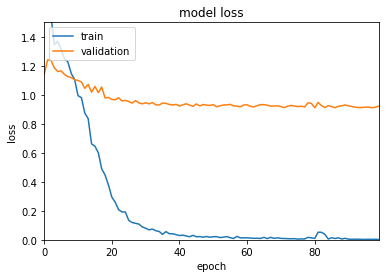

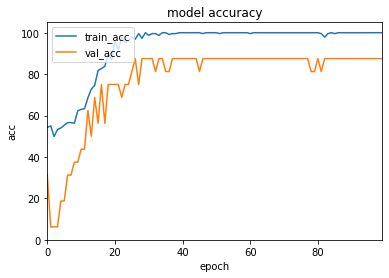

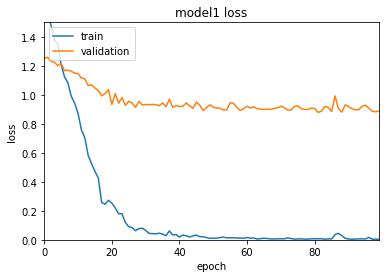

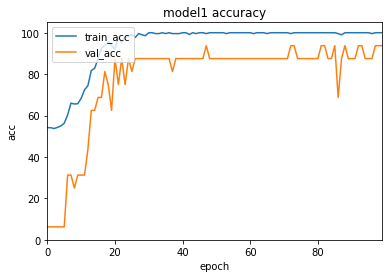

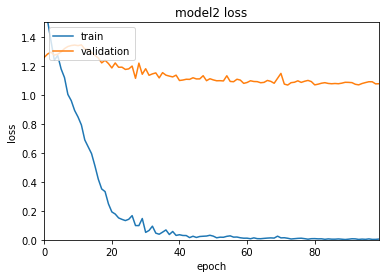

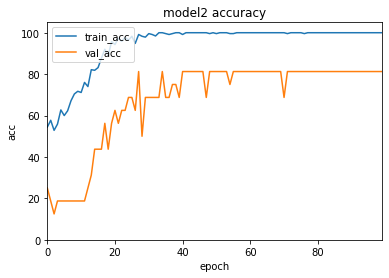

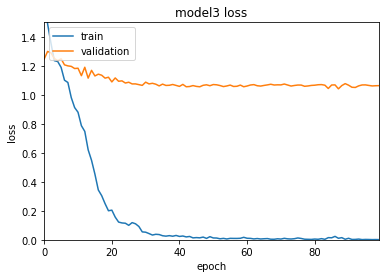

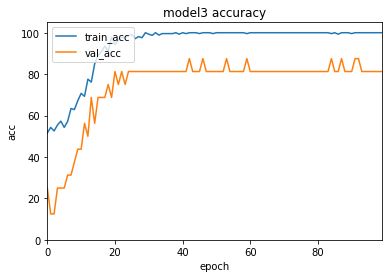

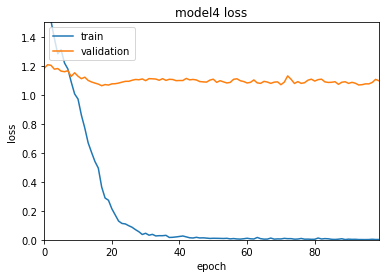

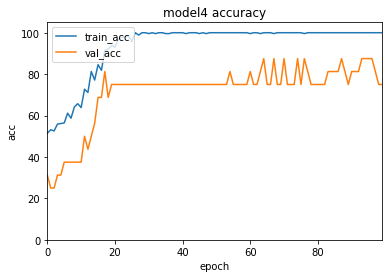

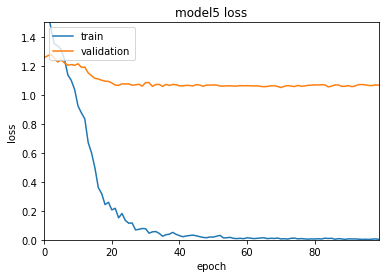

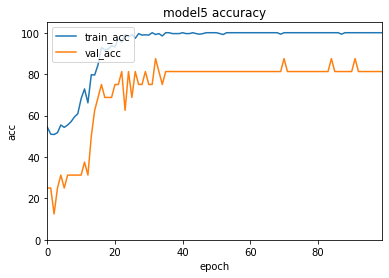

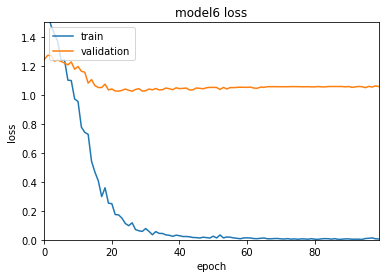

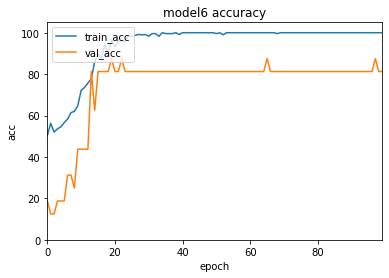

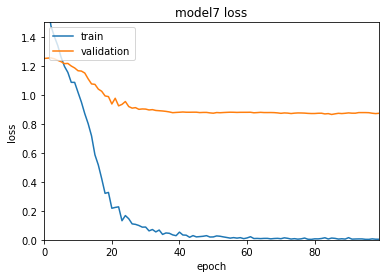

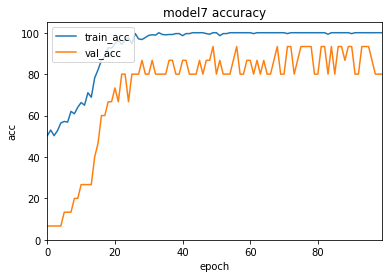

In [20]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  87.5  PPV |  [0.93333333 0.        ]  Recall |  [0.93333333 0.        ]


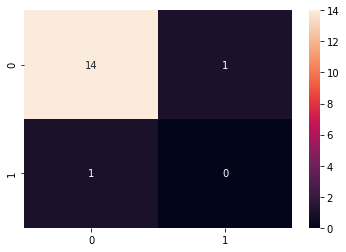

In [21]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  93.75  PPV |  [0.9375 0.    ]  Recall |  [1. 0.]


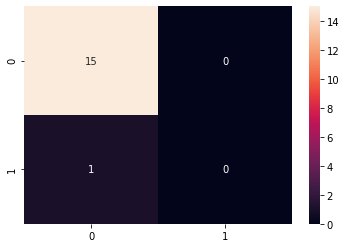

In [22]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


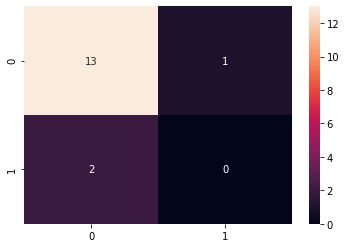

In [23]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


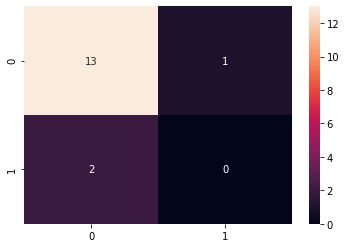

In [24]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]


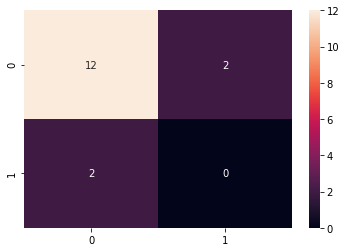

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


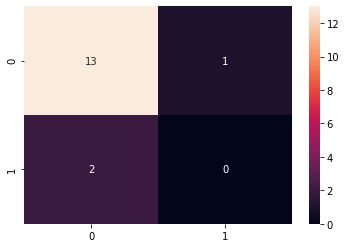

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


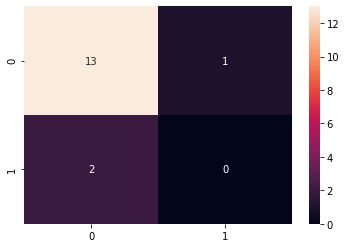

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  80.0  PPV |  [0.92307692 0.        ]  Recall |  [0.85714286 0.        ]


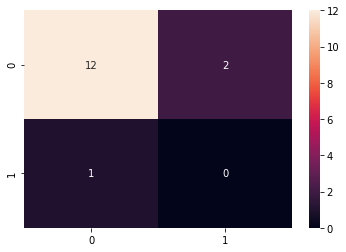

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [29]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0]

[[105   9]
 [ 13   0]]
Positive Predictive Value tp/(tp+fp):  0.0
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.8267716535433071
Recall Value tp/(tp+fn):  0.0


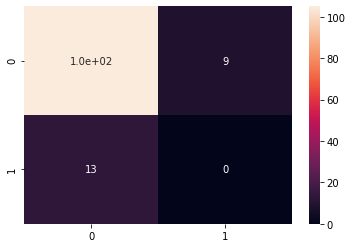

In [30]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 